<a href="https://www.kaggle.com/code/dochanh/inceptionv3-27-11?scriptVersionId=209968416" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Step 1: Import necessary libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [2]:
# Step 2: Prepare dataset paths and labels
data_dir = "/kaggle/input/top-agriculture-crop-disease/Crop Diseases"  # Replace with your dataset path
classes = sorted(os.listdir(data_dir))  # Get folder names as class labels

# Initialize image paths and labels
image_files = []
labels = []

# Map each image to its respective class label based on folder name
for label, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            image_files.append(os.path.join(class_dir, image_name))
            labels.append(label)  # Assign the label based on folder index

# Create a DataFrame for better organization
data = pd.DataFrame({"image": image_files, "label": labels})
print(f"Total images: {len(image_files)}")
print(f"Classes: {classes}")

Total images: 13324
Classes: ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight', 'Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight', 'Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Sugarcane_Bacterial Blight', 'Sugarcane_Healthy', 'Sugarcane_Red Rot', 'Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']


In [3]:
# Step 3: Set up K-Fold Cross Validation
n_splits = 5  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize data augmentation for images
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Store fold results for final evaluation
fold_results = []

In [4]:
# Step 4: Train the model for each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
    print(f"\nTraining Fold {fold + 1}/{n_splits}")
    
    # Split data into training and validation sets
    train_data = data.iloc[train_idx].copy()
    val_data = data.iloc[val_idx].copy()

    # Convert labels to string format
    train_data['label'] = train_data['label'].astype(str)
    val_data['label'] = val_data['label'].astype(str)

    # Create generators for training and validation data
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col="image",
        y_col="label",
        target_size=(150, 150),
        batch_size=32,
        class_mode="categorical"
    )
    val_generator = datagen.flow_from_dataframe(
        dataframe=val_data,
        x_col="image",
        y_col="label",
        target_size=(150, 150),
        batch_size=32,
        class_mode="categorical"
    )


Training Fold 1/5
Found 10659 validated image filenames belonging to 17 classes.
Found 2665 validated image filenames belonging to 17 classes.

Training Fold 2/5
Found 10659 validated image filenames belonging to 17 classes.
Found 2665 validated image filenames belonging to 17 classes.

Training Fold 3/5
Found 10659 validated image filenames belonging to 17 classes.
Found 2665 validated image filenames belonging to 17 classes.

Training Fold 4/5
Found 10659 validated image filenames belonging to 17 classes.
Found 2665 validated image filenames belonging to 17 classes.

Training Fold 5/5
Found 10660 validated image filenames belonging to 17 classes.
Found 2664 validated image filenames belonging to 17 classes.


In [5]:
 # Step 5: Build the model
base_model = InceptionV3(weights="imagenet", include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(len(classes), activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

    # Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Step 6: Set up callbacks
checkpoint_path = f"model_fold_{fold + 1}_epoch_{{epoch:02d}}.keras"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max"
)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# Save the best model for the current fold
model_save_path = f"final_model_fold_{fold + 1}.keras"
model.save(model_save_path)
print(f"Model for Fold {fold + 1} saved at {model_save_path}")

# Save fold results
fold_results.append({
    "fold": fold + 1,
    "accuracy": history.history["val_accuracy"][-1],
    "loss": history.history["val_loss"][-1]
})

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732719320.871560      77 service.cc:145] XLA service 0x780a00005cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732719320.871618      77 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732719320.871622      77 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/334 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.0547 - loss: 3.9693       

I0000 00:00:1732719329.964759      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.6642 - loss: 1.2605
Epoch 1: val_accuracy improved from -inf to 0.83183, saving model to model_fold_5_epoch_01.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 273s 756ms/step - accuracy: 0.6647 - loss: 1.2579 - val_accuracy: 0.8318 - val_loss: 0.4720 - learning_rate: 0.0010
Epoch 2/100
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8231 - loss: 0.4852
Epoch 2: val_accuracy did not improve from 0.83183
334/334 ━━━━━━━━━━━━━━━━━━━━ 157s 464ms/step - accuracy: 0.8231 - loss: 0.4852 - val_accuracy: 0.8318 - val_loss: 0.4121 - learning_rate: 0.0010
Epoch 3/100
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8487 - loss: 0.3964
Epoch 3: val_accuracy improved from 0.83183 to 0.86937, saving model to model_fold_5_epoch_03.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 147s 432ms/step - accuracy: 0.8486 - loss: 0.3965 - val_accuracy: 0.8694 - val_loss: 0.3623 - learning_rate: 0.0010
Epoch 4/100
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accur

In [ ]:
# Step 7: Calculate average results across folds
avg_accuracy = np.mean([result["accuracy"] for result in fold_results])
avg_loss = np.mean([result["loss"] for result in fold_results])

print(f"\nAverage Accuracy across folds: {avg_accuracy}")
print(f"Average Loss across folds: {avg_loss}")

In [ ]:
from tensorflow.keras.models import load_model

# Load a saved model
model = load_model("/kaggle/working/final_model_fold_5.keras")

In [ ]:
# Unfreeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Reduce learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune the model
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Fine-tuning typically requires fewer epochs
    callbacks=[early_stop, reduce_lr, checkpoint]
)


In [2]:
import requests
%cd /kaggle/working
# URL của hình ảnh
image_url = "https://www.ndsu.edu/agriculture/sites/default/files/2022-05/Figure_3.jpg"

# Tên tệp lưu trữhttps://www.ndsu.edu/agriculture/sites/default/files/2022-05/Figure_3.jpg
image_name = "downloaded_image.jpg"

# Tải hình ảnh
response = requests.get(image_url)

# Lưu hình ảnh vào file
if response.status_code == 200:
    with open(image_name, "wb") as f:
        f.write(response.content)
    print(f"Hình ảnh đã được tải về và lưu thành: {image_name}")
else:
    print(f"Không thể tải hình ảnh. Mã lỗi: {response.status_code}")


/kaggle/working
Hình ảnh đã được tải về và lưu thành: downloaded_image.jpg


Model loaded successfully!
Class labels: ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight', 'Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight', 'Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Sugarcane_Bacterial Blight', 'Sugarcane_Healthy', 'Sugarcane_Red Rot', 'Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

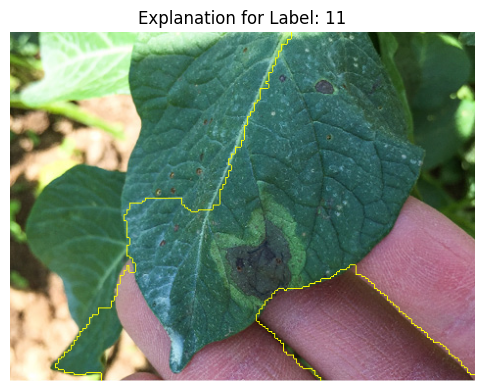

Predicted label: Sugarcane_Bacterial Blight


In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# 1. Tải mô hình đã huấn luyện
model = load_model("/kaggle/input/modeltrained/Final_fine_tuning.keras")  # Thay bằng đường dẫn mô hình của bạn
print("Model loaded successfully!")

# 2. Danh sách nhãn lớp (các class)
class_labels = sorted(os.listdir("/kaggle/input/top-agriculture-crop-disease/Crop Diseases"))  # Thay bằng đường dẫn tập dữ liệu huấn luyện
print(f"Class labels: {class_labels}")

# 3. Hàm xử lý ảnh
def preprocess_input(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Resize ảnh
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0)  # Normalize và thêm batch dimension
    return img_array

# 4. Hàm dự đoán
def predict_fn(images):
    return model.predict(images)

# 5. Hàm giải thích dự đoán với LIME
def explain_prediction(img_path, model, class_labels):
    # Load và xử lý ảnh
    input_image = preprocess_input(img_path)
    explainer = lime_image.LimeImageExplainer()

    # Giải thích ảnh
    explanation = explainer.explain_instance(
        input_image[0],        # Ảnh cần giải thích
        predict_fn,            # Hàm dự đoán
        top_labels=3,          # Số nhãn cần giải thích
        hide_color=0,          # Màu che vùng không liên quan
        num_samples=1000       # Số mẫu cần lấy để giải thích
    )

    return explanation

# 6. Hiển thị vùng giải thích trên ảnh gốc
def display_explanation_on_original(image_path, explanation, label):
    # Load ảnh gốc
    img = image.load_img(image_path)
    img_array = image.img_to_array(img) / 255.0  # Normalize để hiển thị

    # Lấy vùng giải thích từ LIME
    temp, mask = explanation.get_image_and_mask(
        label=label,            # Nhãn cần giải thích
        positive_only=True,     # Chỉ hiển thị vùng hỗ trợ nhãn
        num_features=5,         # Số đặc trưng quan trọng
        hide_rest=False         # Không che phần không quan trọng
    )

    # Resize mặt nạ (mask) để khớp với kích thước ảnh gốc
    mask_resized = resize(mask, img_array.shape[:2], preserve_range=True, anti_aliasing=True)
    mask_resized = mask_resized.astype(bool)  # Chuyển thành boolean mask

    # Đánh dấu vùng giải thích trên ảnh gốc
    explained_image = mark_boundaries(img_array, mask_resized)

    # Hiển thị ảnh với vùng giải thích
    plt.figure(figsize=(6, 6))
    plt.imshow(explained_image)
    plt.title(f"Explanation for Label: {label}")
    plt.axis("off")
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

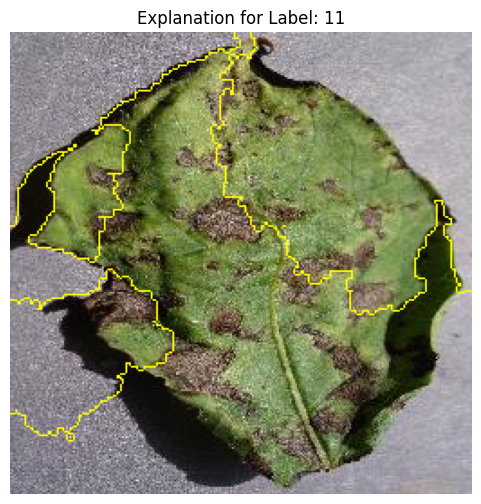

Predicted label: Sugarcane_Bacterial Blight


In [17]:
# 7. Dự đoán và giải thích trên một ảnh
img_path = "/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Potato___Early_Blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG" # Thay bằng đường dẫn ảnh cần dự đoán
explanation = explain_prediction(img_path, model, class_labels)

# Lấy nhãn dự đoán cao nhất
predicted_label_index = explanation.top_labels[0]
predicted_label = class_labels[predicted_label_index]

# Hiển thị vùng giải thích trên ảnh gốc
display_explanation_on_original(img_path, explanation, predicted_label_index)
print(f"Predicted label: {predicted_label}")

In [15]:
from tensorflow.keras.models import load_model

# Tải mô hình đã huấn luyện
model = load_model("/kaggle/input/modeltrained/Final_fine_tuning.keras")

# Lấy tầng cuối cùng của mô hình
output_layer = model.layers[-1]

# Lấy số lượng lớp (số units trong lớp Dense cuối cùng)
num_classes = output_layer.units
print(f"Number of classes in the model: {num_classes}")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Khởi tạo đối tượng ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0 / 255)  # Rescale pixel từ 0-255 về 0-1
train_generator = datagen.flow_from_directory(
    "/kaggle/input/top-agriculture-crop-disease/Crop Diseases",  # Thư mục chứa dữ liệu
    target_size=(150, 150),  # Kích thước ảnh
    batch_size=32,           # Kích thước batch
    class_mode="categorical"  # Dữ liệu là các lớp phân loại
)

# In ánh xạ class indices
print("Class indices mapping:")
print(train_generator.class_indices)

# Đảo ngược ánh xạ để lấy danh sách nhãn
class_labels = {v: k for k, v in train_generator.class_indices.items()}
print("Class labels:")
print(class_labels)


Number of classes in the model: 17
Found 13324 images belonging to 17 classes.
Class indices mapping:
{'Corn___Common_Rust': 0, 'Corn___Gray_Leaf_Spot': 1, 'Corn___Healthy': 2, 'Corn___Northern_Leaf_Blight': 3, 'Potato___Early_Blight': 4, 'Potato___Healthy': 5, 'Potato___Late_Blight': 6, 'Rice___Brown_Spot': 7, 'Rice___Healthy': 8, 'Rice___Leaf_Blast': 9, 'Rice___Neck_Blast': 10, 'Sugarcane_Bacterial Blight': 11, 'Sugarcane_Healthy': 12, 'Sugarcane_Red Rot': 13, 'Wheat___Brown_Rust': 14, 'Wheat___Healthy': 15, 'Wheat___Yellow_Rust': 16}
Class labels:
{0: 'Corn___Common_Rust', 1: 'Corn___Gray_Leaf_Spot', 2: 'Corn___Healthy', 3: 'Corn___Northern_Leaf_Blight', 4: 'Potato___Early_Blight', 5: 'Potato___Healthy', 6: 'Potato___Late_Blight', 7: 'Rice___Brown_Spot', 8: 'Rice___Healthy', 9: 'Rice___Leaf_Blast', 10: 'Rice___Neck_Blast', 11: 'Sugarcane_Bacterial Blight', 12: 'Sugarcane_Healthy', 13: 'Sugarcane_Red Rot', 14: 'Wheat___Brown_Rust', 15: 'Wheat___Healthy', 16: 'Wheat___Yellow_Rust'}


In [ ]:
import matplotlib.pyplot as plt

# Plot training results for the current fold
def plot_training_history(history, fold):
    # Extract metrics
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create a figure
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'Accuracy for Fold {fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss for Fold {fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save the plot
    plot_path = f"training_plot_fold_{fold}.png"
    plt.savefig(plot_path)
    plt.show()
    print(f"Training plot for Fold {fold} saved at {plot_path}")

# Call the function after training each fold
plot_training_history(history, fold + 1)


In [ ]:
# Plot and save training history
plot_training_history(history, fold + 1)


In [ ]:
# Plot combined results across folds
def plot_combined_results(fold_results):
    folds = [result['fold'] for result in fold_results]
    accuracies = [result['accuracy'] for result in fold_results]
    losses = [result['loss'] for result in fold_results]

    # Create a figure
    plt.figure(figsize=(8, 6))

    # Plot accuracy and loss for each fold
    plt.plot(folds, accuracies, label='Validation Accuracy', marker='o')
    plt.plot(folds, losses, label='Validation Loss', marker='o')
    plt.title('Validation Metrics Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('Metrics')
    plt.xticks(folds)
    plt.legend()

    # Save the plot
    combined_plot_path = "combined_training_results.png"
    plt.savefig(combined_plot_path)
    plt.show()
    print(f"Combined training plot saved at {combined_plot_path}")

# Call the function after all folds are trained
plot_combined_results(fold_results)
